# scVelo on gCap in young D28


### Import packages & data

In [ ]:
import sys
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")


In [ ]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [ ]:
adata = scv.read("Bleo_OD28_CECs_gCap_final.h5ad")
adata.var = adata.var.set_index('_index')
adata

AnnData object with n_obs × n_vars = 978 × 23379
    obs: 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_SCT_sf', 'nFeature_SCT_sf', 'clusters', 'condition', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_SCT_uf', 'nFeature_SCT_uf', 'nCount_RNA', 'nFeature_RNA'
    var: 'features', 'spliced_features', 'unspliced_features'
    obsm: 'X_umap'
    layers: 'spliced', 'unspliced'

In [ ]:
adata.var 

features spliced_features unspliced_features
_index                                                          
Gnai3                  Gnai3            Gnai3              Gnai3
Gpr107                Gpr107           Gpr107             Gpr107
Lhx2                    Lhx2             Lhx2               Lhx2
Cdh4                    Cdh4             Cdh4               Cdh4
Ckmt1                  Ckmt1            Ckmt1              Ckmt1
...                      ...              ...                ...
Gm50102              Gm50102          Gm50102            Gm50102
Gm44505              Gm44505          Gm44505            Gm44505
Gm52954              Gm52954          Gm52954            Gm52954
A930007A09Rik  A930007A09Rik    A930007A09Rik      A930007A09Rik
Gm17315              Gm17315          Gm17315            Gm17315

[23379 rows x 3 columns]

In [ ]:
adata.obs['clusters'].value_counts()

2    720
1    205
0     53
Name: clusters, dtype: int64

In [ ]:
old_to_new = {
0:'sCap',
1:'Lrg1+ gCap',
2:'gCap'
}
adata.obs['clusters'] = (
adata.obs['clusters']
.map(old_to_new)
.astype('category')
)

old_to_new = {
0:'PBS',
1:'Bleo'
}
adata.obs['condition'] = (
adata.obs['condition']
.map(old_to_new)
.astype('category')
)

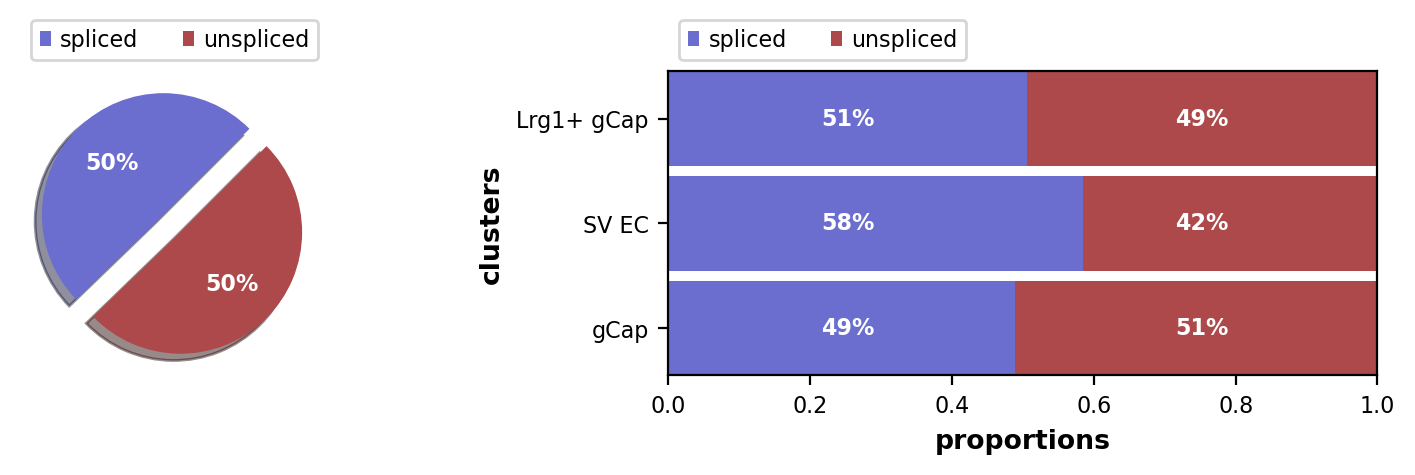

In [ ]:
scv.pl.proportions(adata)


### Pre-process the data

In [8]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=3000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 21038 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### Run scVelo

In [ ]:
scv.tl.recover_dynamics(adata, n_jobs=6)

recovering dynamics (using 6/8 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:10) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [ ]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


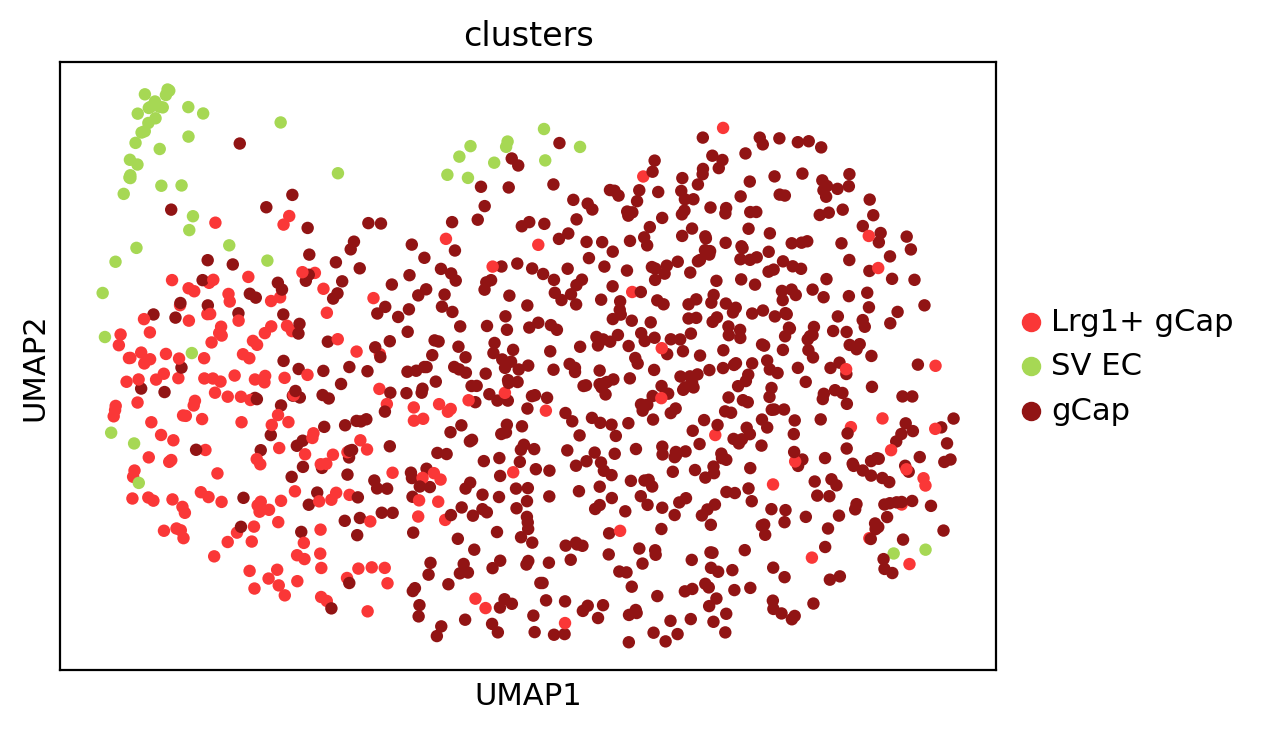

In [ ]:
sc.pl.umap(adata, color="clusters",palette=[ "#fa3737","#911414","#A6D854"  ],size=80)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


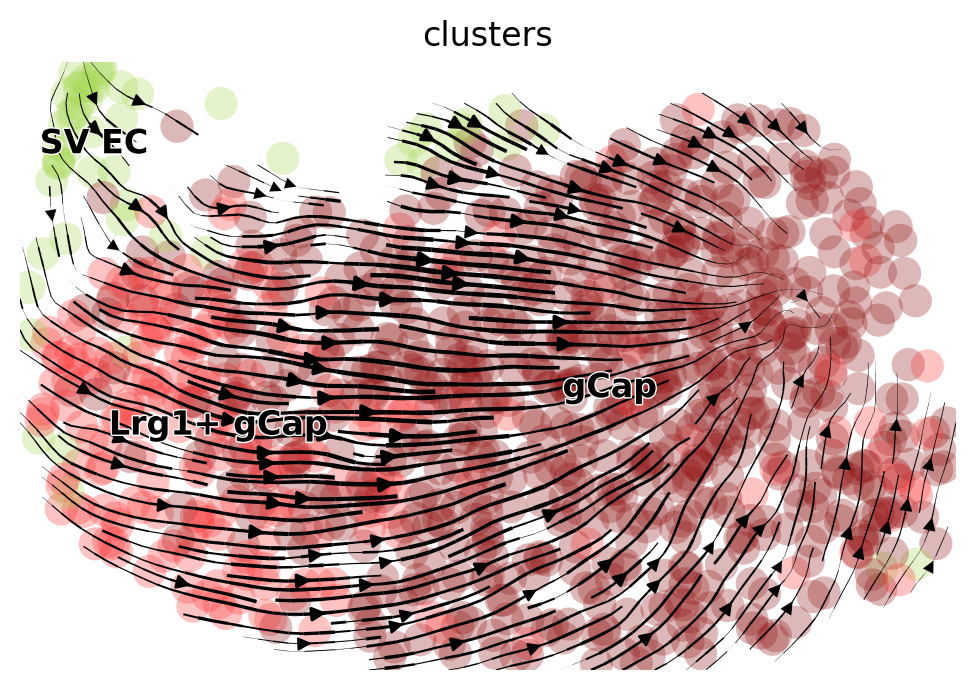

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color="clusters",palette=[ "#fa3737","#911414","#A6D854" ])


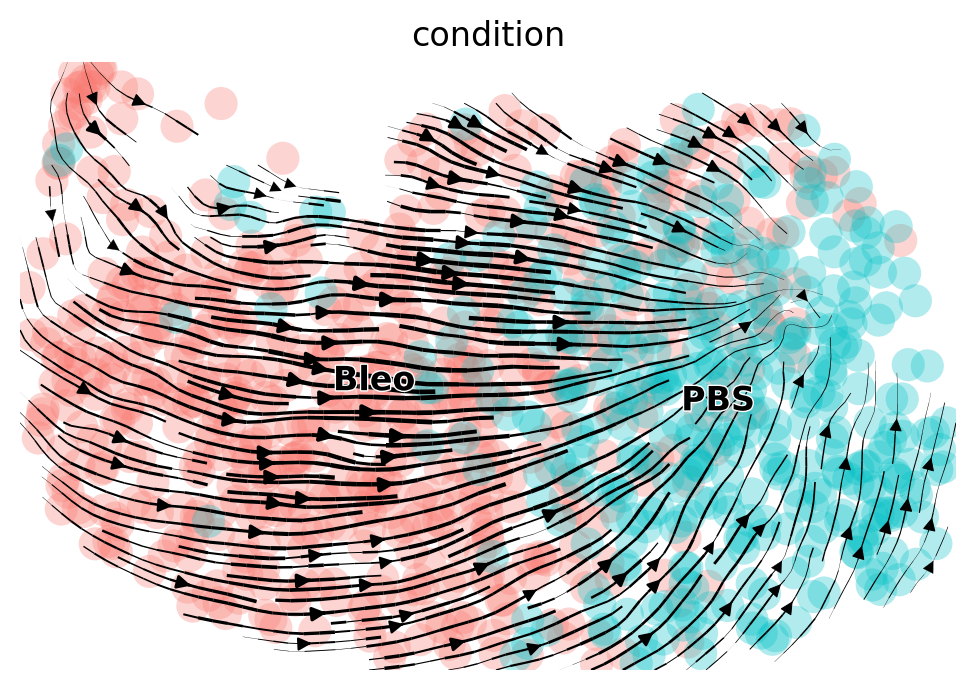

In [13]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color="condition",palette=["#F8766D", "#00BFC4"])

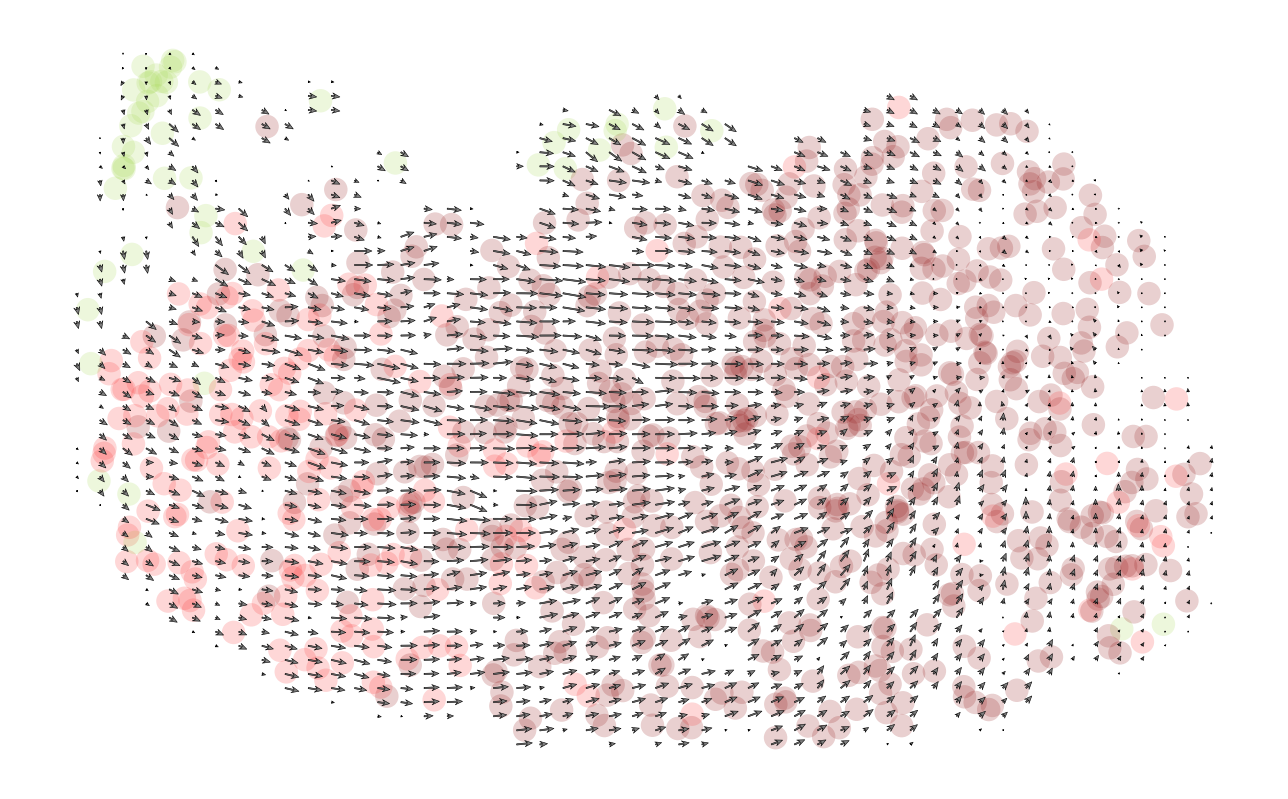

In [14]:
scv.pl.velocity_embedding_grid(adata, basis='umap', color='clusters', title='', scale=0.25,figsize = (8,5))

In [15]:
scv.tl.latent_time(adata)

computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


saving figure to file ./figures/scvelo_Fig6_B_latent_time.pdf


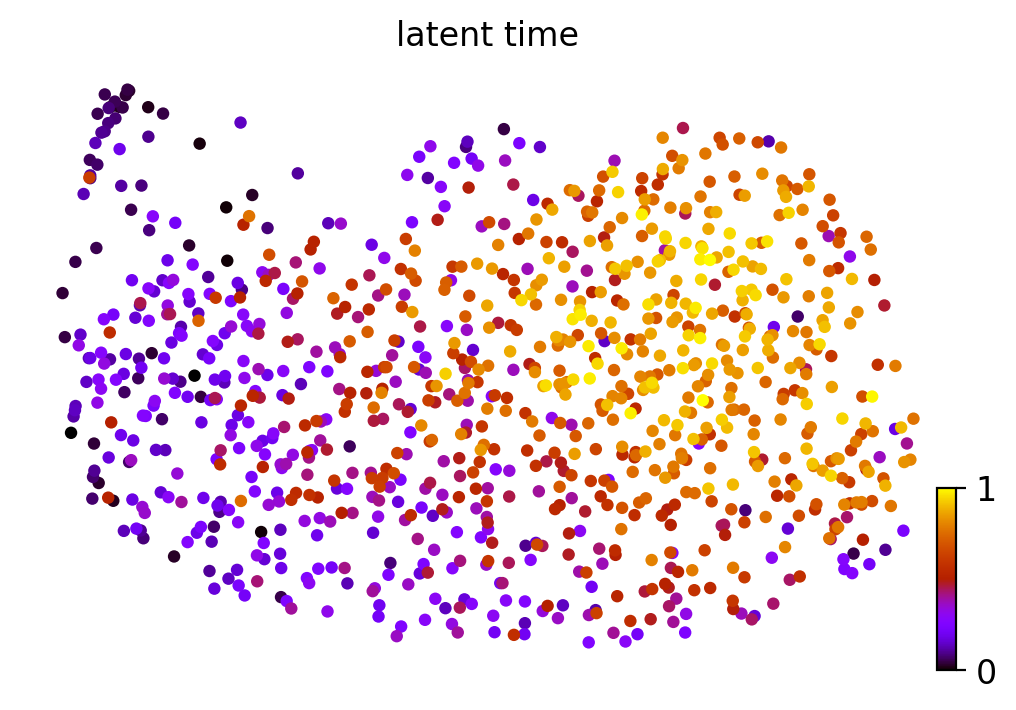

In [16]:
scv.pl.scatter(adata, color="latent_time", color_map="gnuplot",size=80,save = "OD28_latent_time.pdf")

In [17]:
sc.tl.diffmap(adata, n_comps=15, neighbors_key=None, random_state=0, copy=False)
adata.obsm["X_diffmap_"] = adata.obsm["X_diffmap"][:, 1:] 

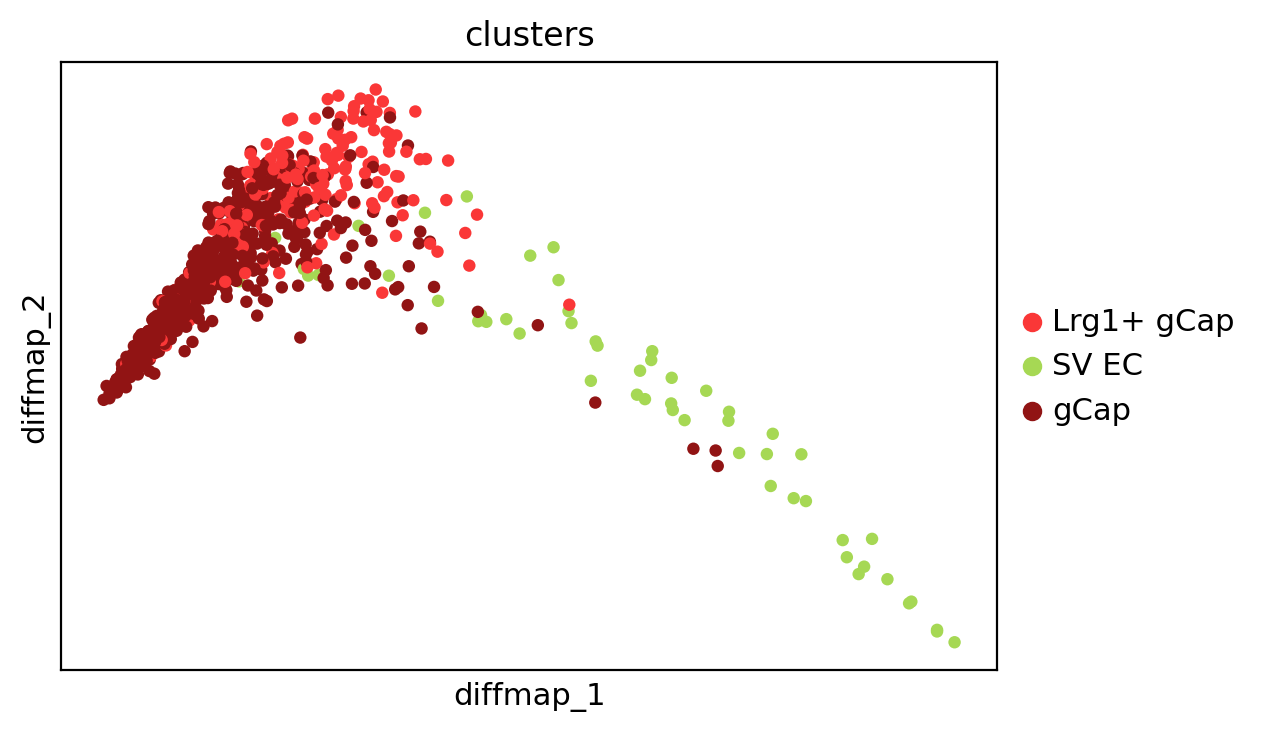

In [ ]:
sc.pl.embedding(adata, "diffmap_", color="clusters",palette=[ "#fa3737","#A6D854","#911414"],size=80,save = "Fig6A.pdf")

saving figure to file ./figures/scvelo_YD14_latent_time.pdf


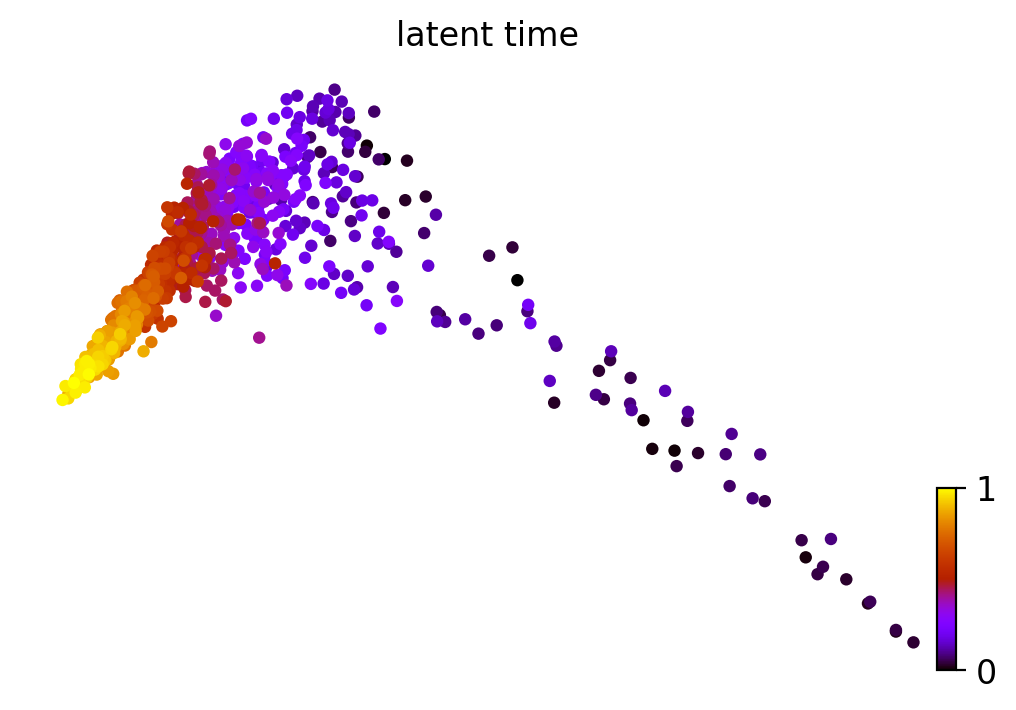

In [ ]:
scv.pl.scatter(adata, basis = "diffmap",color="latent_time", color_map="gnuplot",size=80,save = "Fig6B_latent_time.pdf")

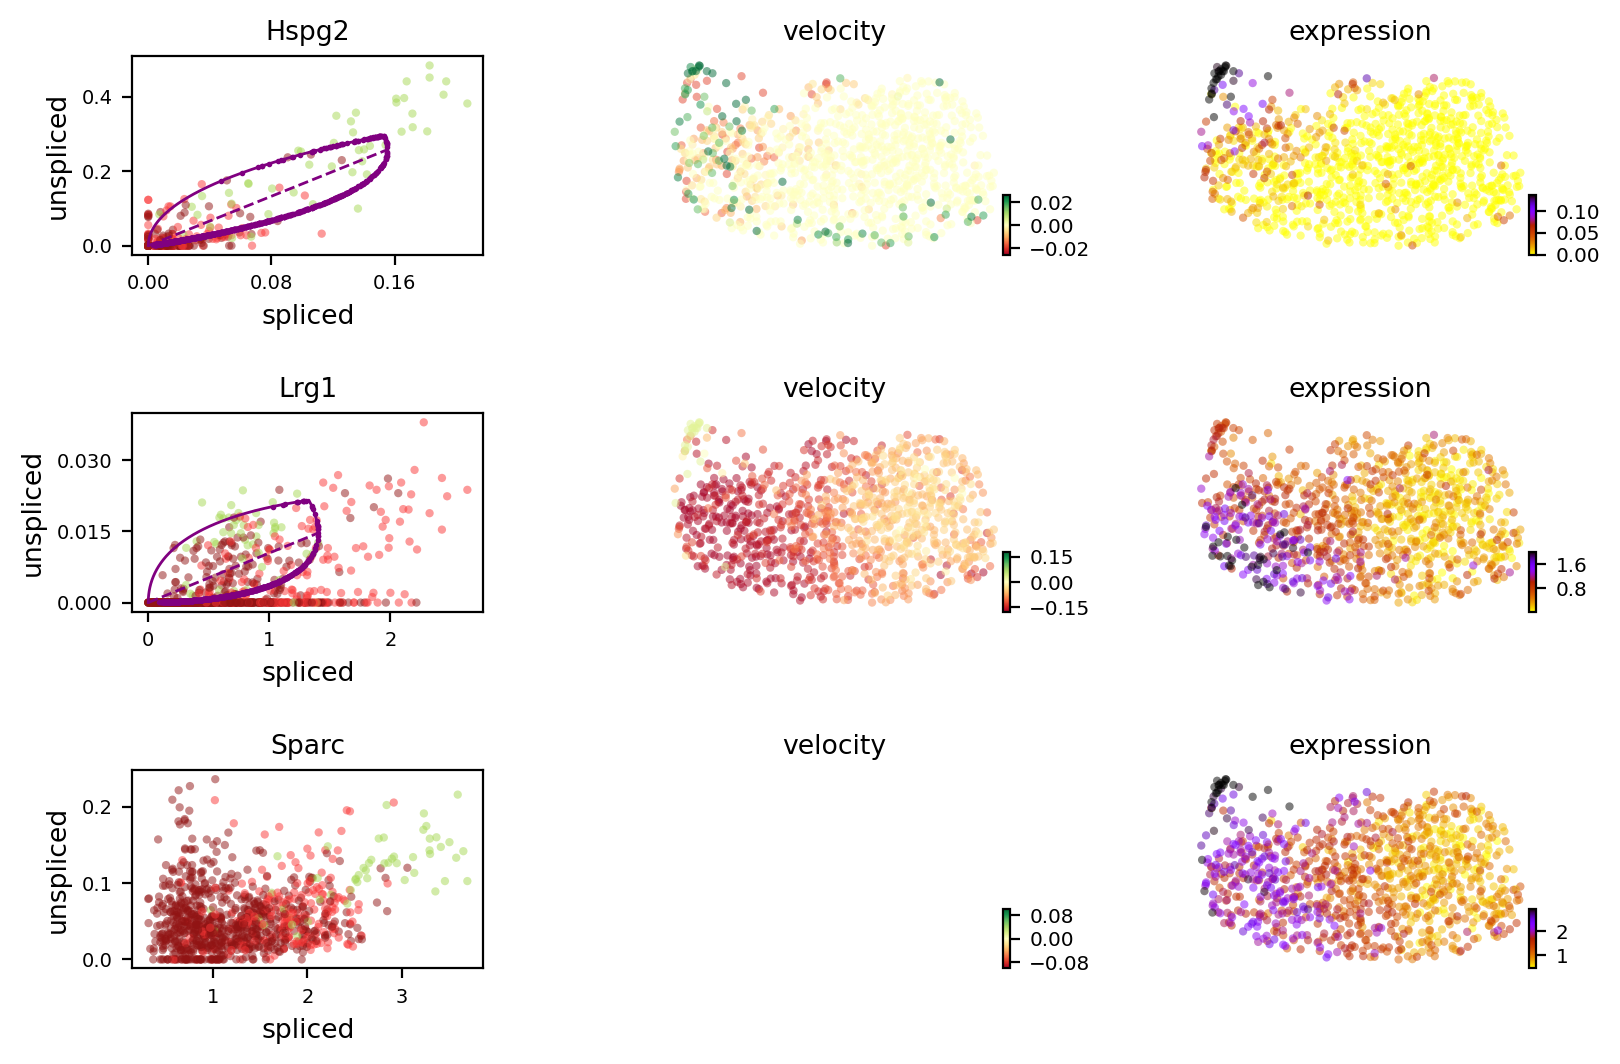

In [34]:
scv.pl.velocity(adata, ['Hspg2', 'Lrg1',  'Sparc'],color="clusters", ncols=1)

In [35]:
top_genes = adata.var["fit_likelihood"].sort_values(ascending=False).index[:50]
top_genes

Index(['Ccl4', 'Sema3c', 'Hpgd', 'Tmem100', 'Ccl3', 'Slc6a6', 'Calcrl',
       'Col4a2', 'Atp8b1', 'Hspg2', 'Ildr2', 'Lama4', 'Scn7a', 'Golm2',
       'Hmcn1', 'Pde3a', 'Abca1', 'Bank1', 'Smad6', 'Tspan7', 'Cyp4b1', 'Rgcc',
       'Cdk19', 'Col4a1', 'Epas1', 'Lama1', 'Abi3bp', 'Dnah3', 'Sparcl1',
       'Vegfc', 'Man1a', 'Crip2', 'Ackr3', 'Sox17', 'Cd36', 'Scn3b', 'Tgfbr2',
       'Podxl', 'Vwf', 'Scarb1', 'Gda', 'Ahr', 'Litaf', 'Cmah', 'Samd9l',
       'Nrp2', 'Chordc1', 'Igf2bp3', 'Lrg1', 'H3f3b'],
      dtype='object', name='_index')

saving figure to file ./figures/scvelo_heatmap.pdf


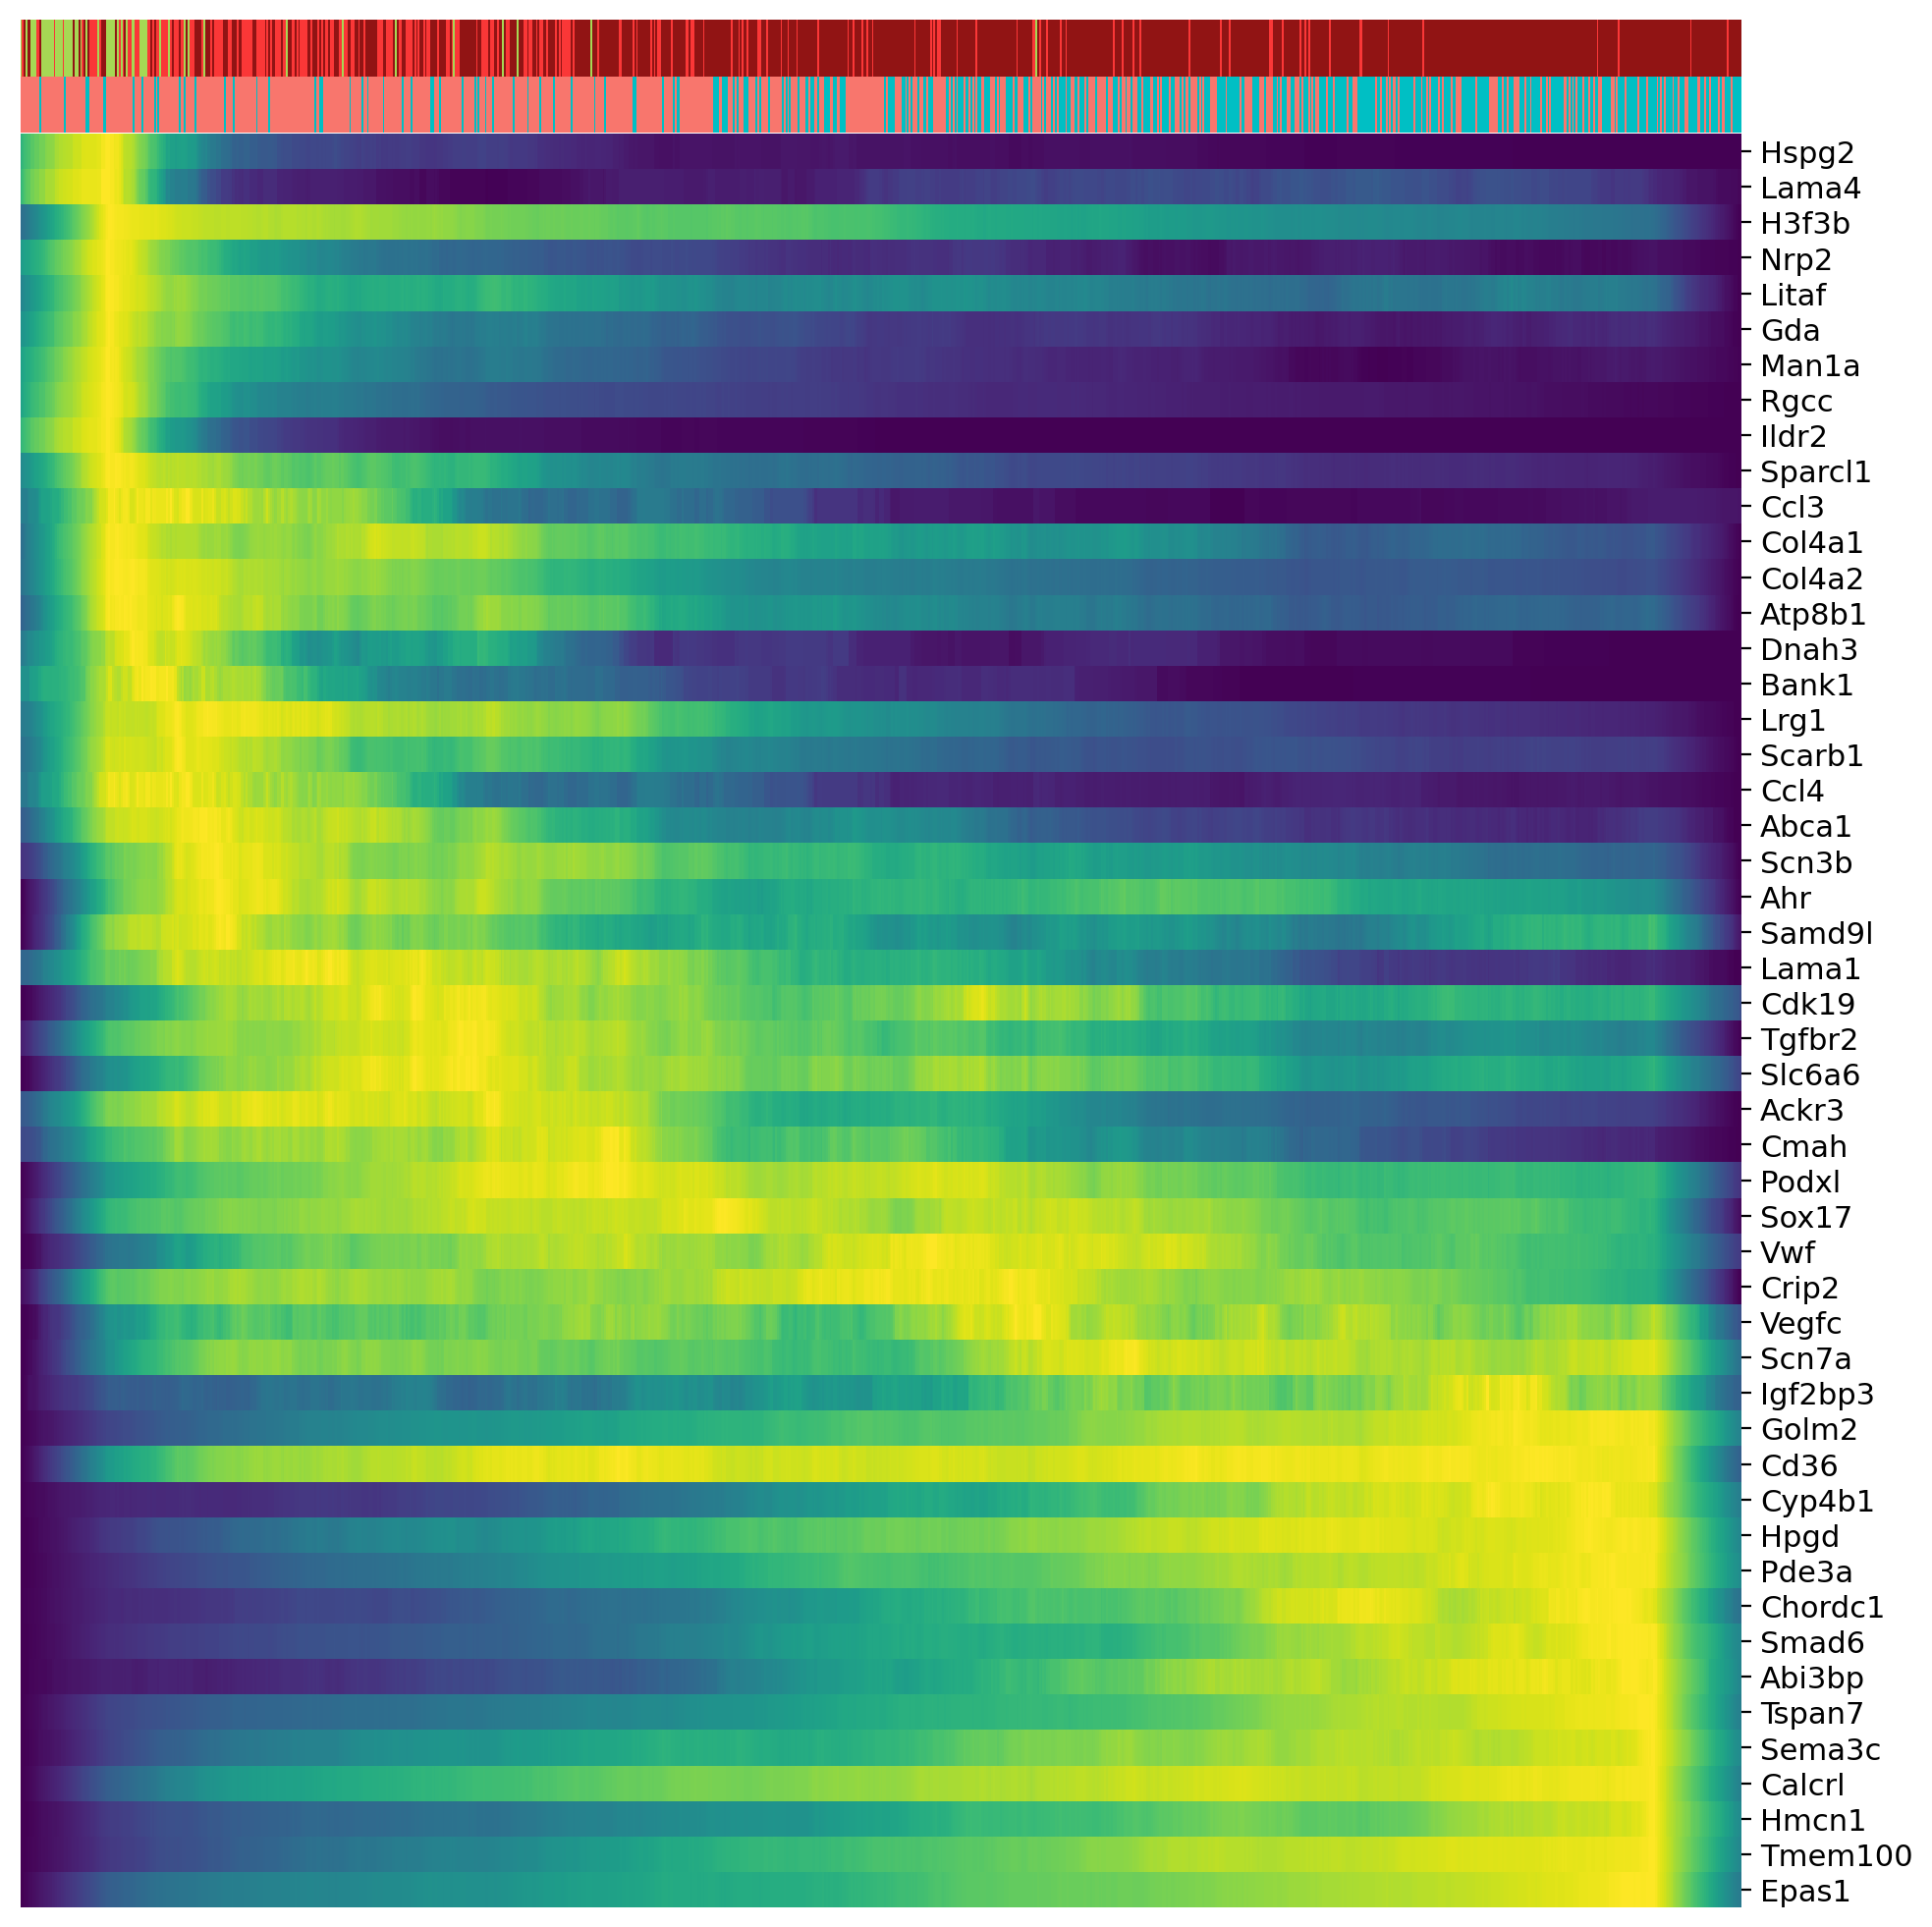

In [ ]:
scv.pl.heatmap(adata, var_names=top_genes, sortby="latent_time", col_color=["clusters","condition"],figsize = (10,10), n_convolve=100,save=False,yticklabels=True)

saving figure to file ./figures/scvelo_heatmap.pdf


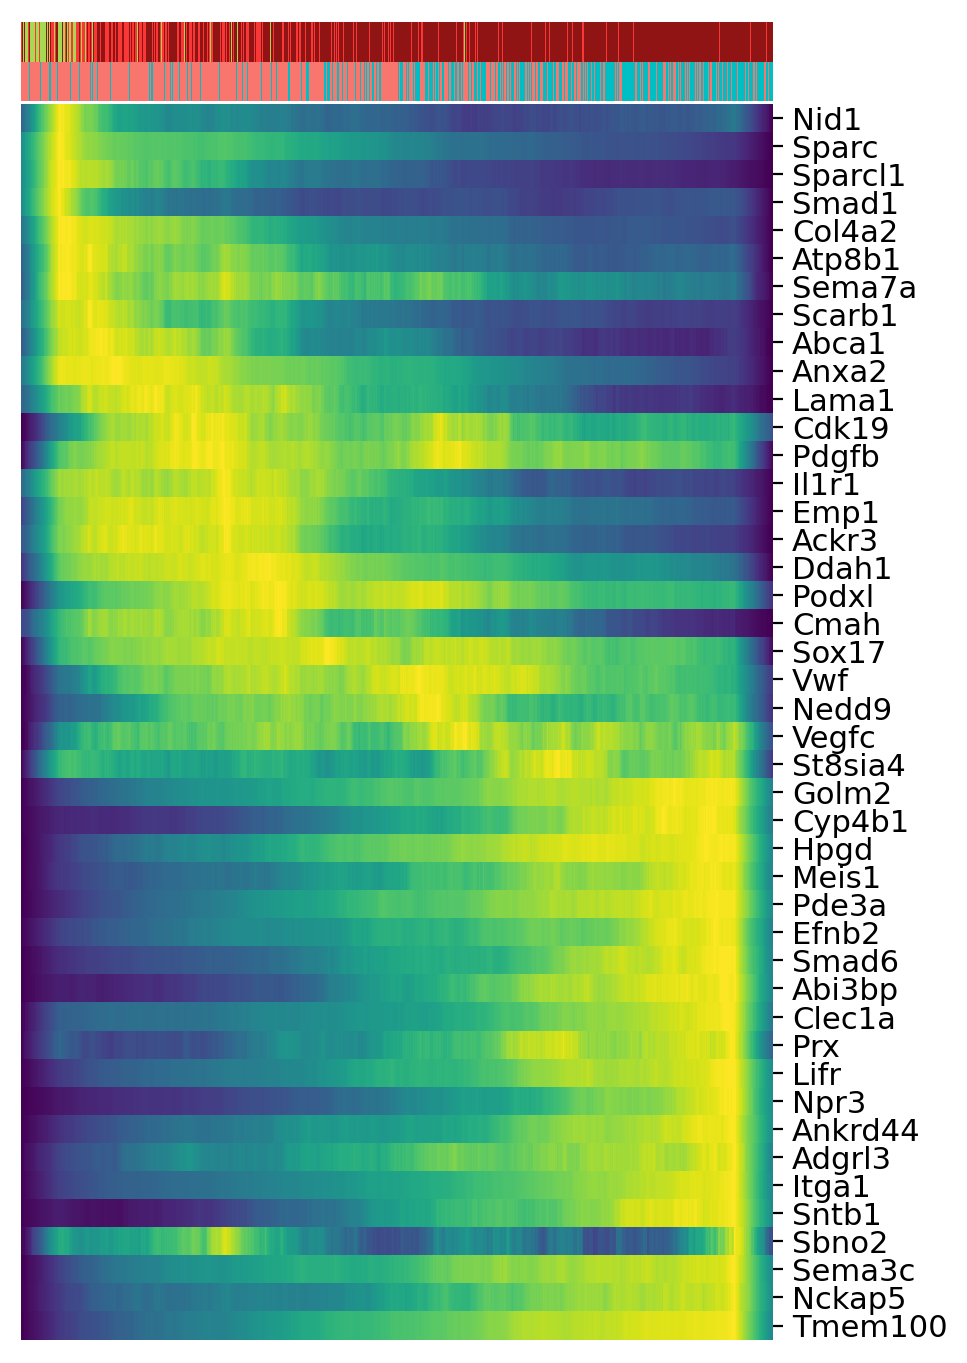

In [ ]:
top_genes = ['Hpgd', 'Tmem100', 'Scarb1', 'Sparc', 'Col4a2','Sparcl1', 'Emp1', 'Ackr3', 'Sema3c', 'Npr3',
       'Clec1a', 'Lama1', 'Itga1', 'Cdk19', 'Efnb2', 'Abca1', 'Glod5',
       'Ankrd44', 'Sntb1', 'Podxl', 'Sbno2', 'Smad1', 'Cyp4b1', 'Cmah',
       'Nckap5', 'Sema7a', 'Smad6', 'Lifr', 'Golm2', 'Vwf', 'Vegfc', 'Atp8b1',
       'Ddah1', 'Ndrg1', 'Sox17', 'Nedd9', 'Abi3bp', 'St8sia4', 'Meis1', 'Prx',
       'Il1r1', 'Pde3a', 'Pdgfb', 'Adgrl3', 'Nid1', 'Anxa2']
scv.pl.heatmap(adata, var_names=top_genes, sortby="latent_time",colorbar=True,row_cluster = False,save=True ,col_color=["clusters","condition"],figsize = (5,7), n_convolve=100,save="Fig6_D_heatmap.pdf",yticklabels=True)

In [38]:
adata.var["fit_likelihood"].sort_values(ascending=False)

_index
Ccl4              0.599354
Sema3c            0.506308
Hpgd              0.427799
Tmem100           0.363990
Ccl3              0.355648
                    ...   
Psmb9                  NaN
X2610037D02Rik         NaN
Bvht                   NaN
Gm7072                 NaN
Tmem223                NaN
Name: fit_likelihood, Length: 2341, dtype: float64

In [39]:
top_genes = adata.var["fit_likelihood"].sort_values(ascending=False).index[:100]
top_genes

Index(['Ccl4', 'Sema3c', 'Hpgd', 'Tmem100', 'Ccl3', 'Slc6a6', 'Calcrl',
       'Col4a2', 'Atp8b1', 'Hspg2', 'Ildr2', 'Lama4', 'Scn7a', 'Golm2',
       'Hmcn1', 'Pde3a', 'Abca1', 'Bank1', 'Smad6', 'Tspan7', 'Cyp4b1', 'Rgcc',
       'Cdk19', 'Col4a1', 'Epas1', 'Lama1', 'Abi3bp', 'Dnah3', 'Sparcl1',
       'Vegfc', 'Man1a', 'Crip2', 'Ackr3', 'Sox17', 'Cd36', 'Scn3b', 'Tgfbr2',
       'Podxl', 'Vwf', 'Scarb1', 'Gda', 'Ahr', 'Litaf', 'Cmah', 'Samd9l',
       'Nrp2', 'Chordc1', 'Igf2bp3', 'Lrg1', 'H3f3b', 'Mctp1', 'Ugcg', 'Emcn',
       'Smad7', 'Rpl23', 'Npr3', 'Adamts1', 'Klf9', 'Polr1d', 'Hhex', 'Pim1',
       'Fau', 'Pdlim1', 'Chmp4b', 'Atp13a3', 'Ankrd37', 'Serinc3', 'Clic1',
       'Capzb', 'Stk17b', 'Smad1', 'Cxcl12', 'Tnfrsf11b', 'Ndfip1', 'H2.Aa',
       'Lyve1', 'Eef1a1', 'Sec62', 'Rpl26', 'Idnk', 'Pcdh17', 'Nr5a2',
       'Tmem176b', 'Vim', 'Serpine1', 'Eng', 'Gja4', 'Pfdn5', 'Sem1', 'Calm1',
       'Rplp0', 'Hnrnpa2b1', 'Nr2f2', 'Dynlrb1', 'Clu', 'Eif1', 'Plac8',
       'Ifitm3',

In [ ]:
adata.var.to_csv(path_or_buf = 'velo_important_genes.tsv', sep = '\t')

In [ ]:
scv.tl.rank_velocity_genes(adata, groupby='clusters', min_corr=.3)

df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes
    finished (0:00:05) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


Lrg1+ gCap    SV EC    gCap
0      Podxl      Kdr  Col4a2
1     Fnbp1l    Palmd   Hmcn1
2        Gda    Hspg2  Sema3c
3       Bcam  Adamts1    Klf9
4       Jam2    Plpp3   Il4ra

In [ ]:
adata.obs.to_csv(path_or_buf = 'velo_metadata.tsv', sep = '\t')